# Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_map, devices
import jax.example_libraries.optimizers as jeo

from tqdm import trange
import pickle

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [3]:
num_mach = 10
attemptno = 1

# Prior Functions

In [4]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [5]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Obtaining Training Data

## Importing Spike Trains and Finger Movement

In [6]:
alldata = pd.read_hdf('./Data/Allfinger_veldata.h5') # Import DataFrame

In [7]:
alldata.xs(0)

signal_type            finger_vel           spikes                           \
channel                         x         y    201  203  204  301  401  601   
0 days 00:00:00         -2.995598  1.402503    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  -3.001671  1.410808    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  -3.007234  1.418926    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  -3.012289  1.426852    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  -3.016839  1.434584    0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...       ...    ...  ...  ...  ...  ...  ...   
0 days 00:02:39.908000   1.950948  5.891312    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.909000   1.911012  5.897290    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.910000   1.872219  5.902874    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.911000   1.834555  5.908068    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.912000   1.798005  5.912879    0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       ...                                          \
channel                 701  802  ... 9001 9103 9201 9203 9301 9403 9501 9502   
0 days 00:00:00         0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:02:39.908000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.909000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.910000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.911000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:39.912000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       
channel                9601 9602  
0 days 00:00:00         0.0  0.0  
0 days 00:00:00.001000  0.0  0.0  
0 days 00:00:00.002000  0.0  0.0  
0 days 00:00:00.003000  0.0  0.0  
0 days 00:00:00.004000  0.0  0.0  
...                     ...  ...  
0 days 00:02:39.908000  0.0  0.0  
0 days 00:02:39.909000  0.0  0.0  
0 days 00:02:39.910000  0.0  0.0  
0 days 00:02:39.911000  0.0  0.0  
0 days 00:02:39.912000  0.0  0.0  

[159913 rows x 132 columns]

In [8]:
trainind = (0, 1, 2)

In [9]:
alldata.loc[0].to_numpy().shape

(159913, 132)

In [10]:
data = [alldata.loc[i] for i in trainind]

In [11]:
data[2]

signal_type            finger_vel           spikes                           \
channel                         x         y    201  203  204  301  401  601   
0 days 00:00:00         -0.391595  0.598059    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  -0.389108  0.584754    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  -0.387002  0.571926    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  -0.385276  0.559577    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  -0.383921  0.547705    0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...       ...    ...  ...  ...  ...  ...  ...   
0 days 00:02:41.916000  -0.409614 -1.557836    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.917000  -0.417498 -1.572530    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.918000  -0.425806 -1.586831    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.919000  -0.434551 -1.600731    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.920000  -0.443748 -1.614225    0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       ...                                          \
channel                 701  802  ... 9001 9103 9201 9203 9301 9403 9501 9502   
0 days 00:00:00         0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:02:41.916000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.917000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.918000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.919000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.920000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       
channel                9601 9602  
0 days 00:00:00         0.0  0.0  
0 days 00:00:00.001000  0.0  0.0  
0 days 00:00:00.002000  0.0  0.0  
0 days 00:00:00.003000  0.0  0.0  
0 days 00:00:00.004000  0.0  0.0  
...                     ...  ...  
0 days 00:02:41.916000  0.0  0.0  
0 days 00:02:41.917000  0.0  0.0  
0 days 00:02:41.918000  0.0  0.0  
0 days 00:02:41.919000  0.0  0.0  
0 days 00:02:41.920000  0.0  0.0  

[161921 rows x 132 columns]

In [12]:
datlen = [len(i.index) for i in data]
print(min(datlen))

159913


In [13]:
# Set number of time bins (k) and number of filters to use, num_tbin cannot exceed the minimum length in the training set!
num_tbin = 159913
n = num_tbin - 1
num_filt = 130
batch_size = num_filt // num_mach
num_filt = num_mach * batch_size
print(num_filt)

130


In [14]:
# All to correspond to dims (nummach, numsam, numfilt, k + 1, 1)

In [15]:
spikedat = [data[i].spikes.to_numpy()[:num_tbin, :num_filt].T[:, :, None] for i in trainind]

In [16]:
print(spikedat[2].shape)

(130, 159913, 1)


In [17]:
ytime = [(data[i].index / np.timedelta64(1, 's')).to_numpy()[:num_tbin] for i in trainind] # Get spikes/output time array

In [18]:
# Get x and y velocities
yraw = [data[i].finger_vel.y.to_numpy()[:num_tbin].reshape(n + 1, 1) for i in trainind]
xraw = [data[i].finger_vel.x.to_numpy()[:num_tbin].reshape(n + 1, 1) for i in trainind]

In [19]:
yraw[0].shape

(159913, 1)

## Standardising Data

In [20]:
# Set variance to 1.0
yvel = [yraw[i] / np.std(yraw[i]) for i in trainind]
xvel = [xraw[i] / np.std(xraw[i]) for i in trainind]

In [21]:
del data # Clear data from memory
del alldata

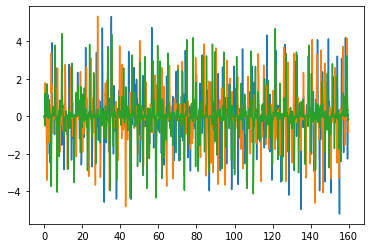

In [22]:
for i in trainind:
  plt.plot(ytime[i], yvel[i])

## Setting up Filter Sizes

In [23]:
# Time bin size
time_bin = ytime[0][1] - ytime[0][0]
print(time_bin)

f_maxt = 1.0 # Filter horizon

k = np.floor(f_maxt/time_bin).astype(np.int16) # Maximum index of filter data

ftime = np.linspace(0.0, f_maxt, k + 1).reshape((k + 1, 1)) # Filter corresponding time array

0.001


## Getting FFT of Spike Data

In [24]:
# FFT of spike train
spikepad = [np.hstack((spikedat[i], np.zeros((num_filt, k, 1)))) for i in trainind]
spikefft = [np.fft.rfft(spikepad[i], axis=1) for i in trainind]
fftlen = [np.shape(spikefft[i])[1] for i in trainind]
spikefft = [spikefft[i].reshape(num_mach, batch_size, fftlen[i], 1) for i in trainind]
spikefft = [[spikefft[j][i] for j in range(len(trainind))] for i in range(num_mach)]
spikefft = jnp.asarray(spikefft)
yvel = jnp.asarray(yvel)
xvel = jnp.asarray(xvel)

In [25]:
# spikefft = jnp.asarray([jnp.vstack((i, i)) for i in spikefft])
# yvel = jnp.vstack((yvel, xvel))

In [26]:
print(spikefft.shape)
print(yvel.shape)

(10, 3, 13, 80457, 1)
(3, 159913, 1)


# ELBO 

In [27]:
Diag = vmap(jnp.diag)

In [28]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [29]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [30]:
@jit
def Likelihoods(Predictions, Velocity, Sigma_n, N):
  return - 0.5 * ((N + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Velocity - Predictions)**2, axis = -2)/(Sigma_n ** 2))

In [31]:
Likely = vmap(Likelihoods, in_axes=(0, 0, None, None,))

In [32]:
@partial(jit, static_argnums = (2, 3,))
def Irfft(Fft, Array, K, N):
  return jnp.fft.irfft(Fft * Array, N + K + 1, axis = -2)[:, :, : N + 1].sum(axis = 1)

In [33]:
VIrfft = vmap(Irfft, in_axes=(None, 0, None, None,))

In [34]:
@partial(jit, static_argnums = range(10, 17))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Number_F, Num_Base, M, Num_Filt, Batch_Size, K, N,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys):

  # Creating lag and z-vector         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag) + Lag

  # Creating the L-matrix
  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  # KL term
  KL = 0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Batch_Size * M)

  # Expectation term
  Thetas = random.normal(Subkeys[0], (Number_F, Batch_Size, 1, Num_Base)) * (1.0 / Ell)

  Taus = random.uniform(Subkeys[1], (Number_F, Batch_Size, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Batch_Size, Num_Base, 1))

  Constant = (Sigma_f * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Batch_Size, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise, TauDiff, Lag)

  F_Fft = jnp.fft.rfft(F_Samples, n = N + K + 1, axis = -2)

  Filter_Out = VIrfft(F_Fft, Spike_Fft, K, N)

  Filter = lax.psum(Filter_Out, axis_name="machs")

  Likelihood = Likely(Filter, Velocity, Sigma_n, N).sum(axis=0)

  KL = lax.psum(KL, axis_name="machs")
  Exp = jnp.mean(Likelihood)
                  
  return (KL-Exp)/(Num_Filt * N + 1)

In [35]:
PNeg = pmap(Neg_ELBO, axis_name = "machs", in_axes=(0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, None, None, None, None, None, None, None, 0, None, None, 0,),
            static_broadcasted_argnums = range(10, 17))

In [36]:
test_number_f = 15
test_num_base = 100
test_m = int(3)

test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 1 + 4 * num_mach)
test_subkeys = np.asarray(test_subkeys).astype(np.uint32).reshape(num_mach, 4, 2)

test_sigma_f = 2.0 * np.ones((num_mach, batch_size, 1, 1))# np.arange(num_mach * batch_size).reshape(num_mach, batch_size, 1, 1)
test_ell_f = 0.7 * np.ones((num_mach, batch_size, 1, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_mach, batch_size, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_mach, batch_size, test_m, 1))
test_l_diag = np.ones((num_mach, batch_size, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_mach, batch_size, 1))
test_trise = 0.02 * np.ones((num_mach, batch_size, 1, 1))
test_tdiff = 0.03 * np.ones((num_mach, batch_size, 1, 1))
test_lag = 0.01 * np.ones((num_mach, batch_size, 1, 1))
test_indices = np.tril_indices(test_m, -1)

In [37]:
nelbo = PNeg(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag,
                test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base,
                test_m, num_filt, batch_size, k, n, test_indices, spikefft, yvel, 
                ftime, test_subkeys)

In [38]:
print(nelbo)

[24910.26799101 24910.26799101 24910.26799101 24910.26799101
 24910.26799101 24910.26799101 24910.26799101 24910.26799101
 24910.26799101 24910.26799101]


In [39]:
Grad_Bound = value_and_grad(Neg_ELBO, argnums = range(10))

In [40]:
del test_number_f, test_num_base, test_m, test_key, test_subkeys, test_sigma_f, test_ell_f, test_sigma_n, test_z_final, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag, test_indices

# Training the Model

In [41]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [42]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [43]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [44]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [45]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [46]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [47]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [48]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(CFinState, X, Mhat, Vhat)

  return X, M, V

In [49]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(MFinState, X, Mhat, Vhat)

  return X, M, V

In [50]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_map(MCalc, Grad, M) # First  moment estimate.
  V = tree_map(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_map(FFinState, X, Mhat, Vhat)

  return X, M, V

In [51]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None,  
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 18))

def _CUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Coarse_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = CAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [52]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None, 
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 18))

def _MUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Mid_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = MAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [53]:
@partial(pmap, axis_name = "machs", in_axes=(None, 0, 0, None, 0, 0, 0, 0, 0, 0, 0, None, 
                                    None, None, None, None, None, None, None, 
                                    0, None, None, 0, 0, 0, 0,),
                static_broadcasted_argnums = range(11, 18))

def _FUpdate(Iter, Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
              Indices, Spike_Fft, Velocity, F_Time, Subkeys, Key, Mad, Vad):
  
  Value, Grads = Grad_Bound(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag, Num_Fine_Fs, Num_Base, M, Num_Filt, Batch_Size, K, N,
                  Indices, Spike_Fft, Velocity, F_Time, Subkeys)
  
  X, Mad, Vad = FAdam(Iter, (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag), Grads, Mad, Vad)

  Key, *Subkeys = random.split(Key, 5)
  Subkeys = jnp.asarray(Subkeys).astype(jnp.uint32).reshape(4, 2)

  return *X, Subkeys, Key, Mad, Vad, Value

In [54]:
@partial(pmap, in_axes = (0, 0, None, 0, 0, 0, 0, 0, 0, 0,))
def Init_Adam(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag):
  X = (Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise,
              TauDiff, Lag)

  Mad = tree_map(jnp.zeros_like, X)

  return Mad, Mad
  

# Y Velocity

In [62]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

sigma_f = isigma_f
ell = iell
sigma_n = isigma_n
trise = itrise
taudiff = itaudiff
lag = ilag

# Variational parameters
num_f = 15
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

z_fracs = iz_fracs
v_vector = iv_vector
l_diag = il_diag
l_odiag = il_odiag

# Random number generator
iopt_key = np.asarray([random.PRNGKey(i) for i in range(num_mach)]).astype(np.uint32)
itest = vmap(random.split, in_axes=(0, None))(iopt_key, 1 + 4 * num_mach)
iopt_key = np.asarray([itest[i][0] for i in range(num_mach)]).astype(np.uint32)
iopt_subkey = np.asarray([itest[i][1:] for i in range(num_mach)]).astype(np.uint32)

opt_key = iopt_key
opt_subkey = iopt_subkey
print(opt_subkey.shape)

(10, 40, 2)


In [62]:
mad, vad = Init_Adam(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
              il_odiag, itrise, itaudiff, ilag)

In [63]:
step = 0
elbo_history = np.zeros(20000)

In [64]:
coarse_steps = 1500
mid_steps = 16500
fine_steps = 2000

In [65]:
extra_coarse_steps = 0
extra_mid_steps = 0
extra_fine_steps = 0

In [66]:
elbo_history = np.hstack((elbo_history, np.zeros(sum([extra_coarse_steps, extra_mid_steps, extra_fine_steps]))))

In [67]:
step = 0
for i in trange(coarse_steps):  
  sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _CUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, num_f, num_b, num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, ftime, opt_subkey, opt_key, mad, vad)
  sigma_n = sigma_n[0]
  elbo_history[step] = -value[0]
  step += 1

100%|██████████| 1500/1500 [29:06<00:00,  1.16s/it]


In [68]:
for i in trange(mid_steps):
    sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _MUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                  l_odiag, trise, taudiff, lag, num_f, num_b,
                  num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, 
                  ftime, opt_subkey, opt_key, mad, vad)
    sigma_n = sigma_n[0]
    elbo_history[step] = -value[0]
    step += 1

100%|██████████| 16500/16500 [5:16:15<00:00,  1.15s/it]  


In [69]:
for i in trange(fine_steps):
    sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag, st, kt, mad, vad, value = _FUpdate(i, sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                  l_odiag, trise, taudiff, lag, num_f, num_b,
                  num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, 
                  ftime, opt_subkey, opt_key, mad, vad)
    sigma_n = sigma_n[0]
    elbo_history[step] = -value[0]
    step += 1

100%|██████████| 2000/2000 [38:30<00:00,  1.16s/it]


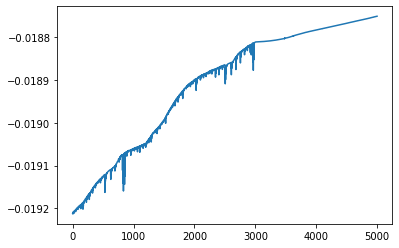

In [70]:
plt.plot(elbo_history[15000:])

In [71]:
print(PNeg(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
                il_odiag, itrise, itaudiff, ilag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, 
                ftime, iopt_subkey))

[2.49026654e+16 2.49026654e+16 2.49026654e+16 2.49026654e+16
 2.49026654e+16 2.49026654e+16 2.49026654e+16 2.49026654e+16
 2.49026654e+16 2.49026654e+16]


In [72]:
print(PNeg(sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag,
                l_odiag, trise, taudiff, lag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, 
                ftime, iopt_subkey))

[0.01875109 0.01875109 0.01875109 0.01875109 0.01875109 0.01875109
 0.01875109 0.01875109 0.01875109 0.01875109]


In [73]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag

In [74]:
youtdict = {"Parameters": (fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag), 
          "ELBO History": elbo_history,
          "Training Sets": trainind,
          "Steps":(coarse_steps, mid_steps, fine_steps, extra_coarse_steps, extra_mid_steps, extra_fine_steps),
          "Initial Parameters": (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag),
          "Training Parameters": (num_f, num_b, num_ind, num_filt),
          "mad": mad, 
          "vad": vad,
          "Velocity Trained": "y"}

In [75]:
with open('./Data/Hyperparameters/LinearSum/' + str(n) + '_' + str(attemptno) + 'yvel' + '.pkl', 'wb') as f:
    pickle.dump(youtdict, f)

In [55]:
with open('./Data/Hyperparameters/LinearSum/' + str(n) + '_' + str(attemptno) + 'yvel' + '.pkl', 'rb') as f:
    youtdict = pickle.load(f)

fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = youtdict["Parameters"]
num_f, num_b, num_ind, num_filt = youtdict["Training Parameters"]

In [56]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [57]:
PDiag = pmap(Diag)

In [58]:
PSet = pmap(Set, in_axes=(0, None, 0,))

In [261]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
print(il_diag.shape)
print(idz.shape)
il_matrix = PSet(idz, indices, il_odiag)


flag = flag ** 2

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = PDiag(np.exp(fl_diag))
fl_matrix = PSet(fd, indices, fl_odiag)
print(fd.shape)
print(fl_matrix.shape)

(10, 13, 20)
(10, 13, 20, 20)
(10, 13, 20, 20)
(10, 13, 20, 20)


In [262]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

fsigma_ff = fsigma_f.reshape(num_filt, 1)
fellf = fell.reshape(num_filt, 1)
fz_vectorf = fz_vector.reshape(num_filt, num_ind, 1)
fv_vectorf = fv_vector.reshape(num_filt, num_ind, 1)
fl_matrixf = fl_matrix.reshape(num_filt, num_ind, num_ind)
ftrisef = ftrise.reshape(num_filt, 1)
ftaudifff = ftaudiff.reshape(num_filt, 1)
flagf = flag.reshape(num_filt, 1)

In [263]:
print(len(spikefft))

10


In [264]:
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(3)]

In [265]:
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(3)]

In [266]:
print(len(spikefftf))
print(spikefftf[0].shape)

3
(130, 80457, 1)


In [267]:
print(fsigma_ff)

[[0.05936409]
 [0.06218676]
 [0.06568347]
 [0.20661855]
 [0.10871733]
 [0.39359494]
 [0.29243354]
 [0.42932269]
 [0.10197101]
 [0.06484449]
 [0.86124581]
 [0.16265877]
 [0.40611576]
 [0.04579743]
 [0.07442001]
 [0.07677012]
 [0.79120648]
 [0.19455015]
 [0.17906286]
 [0.20945264]
 [0.10554368]
 [0.08106003]
 [0.87239766]
 [0.84715584]
 [0.13916824]
 [0.08234141]
 [0.84386108]
 [0.69714112]
 [0.12384819]
 [0.1555588 ]
 [0.15839035]
 [0.48328134]
 [0.06804733]
 [0.88476907]
 [0.81285329]
 [0.43003193]
 [0.28956504]
 [0.13428817]
 [0.3835536 ]
 [0.86651456]
 [0.07185951]
 [0.12057476]
 [0.21915785]
 [0.39214687]
 [0.09034195]
 [0.24629376]
 [0.49932857]
 [0.9173364 ]
 [0.84268433]
 [0.11459452]
 [0.05802884]
 [0.13341724]
 [0.86961151]
 [0.16780241]
 [0.07741954]
 [0.0439275 ]
 [0.47389363]
 [0.11927962]
 [0.12881874]
 [0.12823743]
 [0.04059922]
 [0.20609055]
 [0.24909092]
 [0.22006843]
 [0.86841742]
 [0.03155693]
 [1.04377436]
 [0.14152859]
 [0.85595032]
 [0.114468  ]
 [0.41138066]
 [0.03

In [268]:
print(fellf)

[[ 0.14107141]
 [-0.2007905 ]
 [ 0.14622613]
 [-0.2070936 ]
 [ 0.14654286]
 [-0.13638435]
 [ 0.14668904]
 [ 0.1656854 ]
 [ 0.1029126 ]
 [-0.14430445]
 [ 0.06318089]
 [-0.10230401]
 [ 0.13737292]
 [ 0.06413835]
 [-0.07799861]
 [-0.14277429]
 [ 0.06337702]
 [-0.11733283]
 [ 0.10346586]
 [ 0.12240997]
 [-0.08378415]
 [ 0.08607573]
 [-0.05935458]
 [-0.03773488]
 [ 0.15296807]
 [-0.10097626]
 [ 0.06332897]
 [-0.01284495]
 [-0.14175528]
 [-0.07381792]
 [ 0.11292821]
 [ 0.07816368]
 [-0.12872171]
 [ 0.0633633 ]
 [-0.09254729]
 [ 0.08879375]
 [ 0.10406933]
 [ 0.09408416]
 [ 0.17035429]
 [-0.07243412]
 [ 0.14436102]
 [-0.10979273]
 [ 0.13252163]
 [ 0.11054567]
 [ 0.13082633]
 [-0.10513184]
 [ 0.18486981]
 [ 0.0724227 ]
 [ 0.06467731]
 [ 0.17370309]
 [ 0.10182529]
 [-0.11086645]
 [ 0.06398721]
 [ 0.14418756]
 [ 0.06910063]
 [ 0.10365398]
 [ 0.10365118]
 [ 0.1505474 ]
 [ 0.1396475 ]
 [-0.09755668]
 [-0.07499085]
 [ 0.1066766 ]
 [ 0.19551417]
 [-0.08963128]
 [-0.05999292]
 [-0.09104685]
 [-0.06273

In [269]:
print(fsigma_n)

0.5429057926093097


In [270]:
print(ftrisef)

[[ 3.74887189e-01]
 [-5.31035097e-07]
 [ 2.85704254e-02]
 [ 7.36831884e-02]
 [ 1.52311560e-01]
 [ 1.71778825e-01]
 [-2.23602490e-08]
 [ 6.30201865e-02]
 [ 6.85809700e-01]
 [ 5.16613615e-06]
 [-6.73961640e-04]
 [ 1.13615212e-01]
 [ 7.51168205e-13]
 [-1.94779221e-07]
 [ 1.16221849e-01]
 [ 3.60721505e-01]
 [-1.81367675e-03]
 [ 2.39015097e-02]
 [ 1.57541336e-01]
 [ 1.45624731e-01]
 [ 5.58561814e-46]
 [ 1.80924240e-02]
 [-6.30343726e-04]
 [-6.03363080e-04]
 [-7.85870121e-10]
 [ 2.12905354e-49]
 [-4.32517839e-04]
 [-2.63811030e-03]
 [ 1.58060062e-01]
 [ 1.05359355e-07]
 [ 2.62906805e-03]
 [-2.38514577e-14]
 [ 4.12206892e-01]
 [-2.31493118e-03]
 [ 1.32214127e-01]
 [ 1.36544429e-01]
 [ 1.11695321e-01]
 [-1.36263858e-06]
 [ 1.99103207e-01]
 [ 4.13614862e-03]
 [ 1.78627063e-02]
 [-5.35083580e-07]
 [ 2.09097054e-01]
 [ 1.07634819e-01]
 [ 4.12981774e-03]
 [ 1.45149817e-01]
 [ 2.02122428e-02]
 [ 1.51149794e-03]
 [ 2.98520370e-03]
 [-1.17119720e-05]
 [ 3.94912257e-01]
 [ 1.30410487e-01]
 [ 2.8954539

In [271]:
print(ftaudifff)

[[ 5.21742103e-01]
 [ 6.61172443e-01]
 [ 6.35660676e-01]
 [ 4.76655114e-01]
 [ 6.45218369e-01]
 [ 1.07695366e-01]
 [ 4.79433348e-01]
 [ 3.47440992e-01]
 [ 6.86808049e-01]
 [ 6.21218680e-01]
 [ 1.42381343e-03]
 [ 1.39794281e+00]
 [ 4.30361729e-01]
 [ 1.93354657e-01]
 [ 2.35823694e-02]
 [ 6.84268956e-01]
 [ 1.15033052e-03]
 [ 4.75146559e-01]
 [ 4.04788255e-02]
 [ 2.26381729e-01]
 [ 1.27706640e+00]
 [ 6.14645445e-01]
 [ 2.70958464e-05]
 [-1.83512957e-03]
 [ 5.67450523e-01]
 [ 1.04024553e+00]
 [ 1.99694142e-03]
 [-1.07583952e-05]
 [ 5.14531062e-01]
 [ 6.29739407e-01]
 [ 5.35270124e-01]
 [ 1.50194226e-02]
 [ 5.38422884e-01]
 [ 1.11934076e-04]
 [ 1.78455423e-02]
 [ 3.54069651e-02]
 [ 1.96760643e-01]
 [ 6.82746974e-01]
 [ 4.75579771e-01]
 [-1.17991331e-03]
 [ 6.15256941e-01]
 [ 5.66376775e-01]
 [ 1.60343535e-01]
 [ 1.93264531e-01]
 [ 6.84310461e-01]
 [ 1.89569463e-01]
 [ 2.32395267e-01]
 [ 3.39693273e-04]
 [-4.01515477e-04]
 [ 4.53350280e-01]
 [ 5.39203227e-01]
 [ 4.43580858e-01]
 [-4.1729662

In [272]:
print(flagf)

[[1.15488380e-001]
 [1.36374910e-099]
 [1.57015863e-100]
 [6.84383100e-079]
 [4.24228821e-102]
 [6.91885129e-094]
 [1.89862784e-084]
 [2.09680232e-011]
 [4.16795808e-085]
 [2.51049394e-074]
 [2.44420149e-003]
 [1.49752769e-181]
 [3.31941683e-005]
 [2.69145661e-108]
 [5.53309068e-102]
 [8.10403651e-013]
 [2.55321696e-003]
 [5.42071754e-100]
 [5.31444420e-100]
 [6.14233476e-102]
 [2.13825274e-075]
 [7.04450090e-005]
 [2.96671576e-002]
 [4.05498750e-002]
 [1.13438529e-114]
 [8.85551770e-056]
 [2.53267012e-003]
 [1.64198712e-003]
 [3.83925483e-003]
 [3.33778236e-103]
 [9.84890133e-004]
 [9.47139968e-030]
 [7.36883060e-002]
 [2.04721963e-003]
 [1.28370000e-011]
 [2.67990369e-013]
 [2.53956685e-101]
 [9.24639536e-098]
 [1.19808537e-102]
 [2.60524182e-002]
 [2.36606117e-103]
 [2.24336216e-112]
 [4.73431637e-100]
 [7.33211347e-012]
 [9.63820298e-004]
 [3.06170933e-013]
 [3.02373657e-097]
 [2.57422674e-002]
 [2.36498884e-003]
 [1.51737819e-076]
 [9.85396656e-006]
 [1.66022912e-086]
 [9.17864179

## Variational Predictions

In [273]:
fpred_points = ftime.copy()

In [59]:
@jit
def LowerSolv(MatA, MatB):
  return jsc.linalg.solve_triangular(MatA, MatB, lower = True)

In [60]:
VLS = vmap(LowerSolv)

In [276]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
# ibzast = np.zeros((num_filt, num_ind, k + 1))
# for i in range(num_filt):
#   ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzast = VLS(icpred, ikzast)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [277]:
scfsigmaf = fsigma_ff[:, None]
scfellf = fellf[:, None]
scftrisef = ftrisef[:, None]
scftaudifff = ftaudifff[:, None]
scflagf = flagf[:, None]

fkmm = Squared_exp(fz_vectorf, fz_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vectorf, fpred_points.T, scfsigmaf, scfellf)
fbzast = np.zeros((num_filt, num_ind, k + 1))
# for i in range(num_filt):
#   fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzast = VLS(fcpred, fkzast)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vectorf)

fkastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [278]:
print(imeanpred.shape)

(130, 1001, 1)


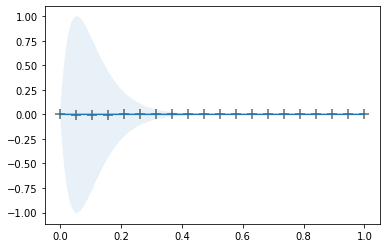

In [279]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 95
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

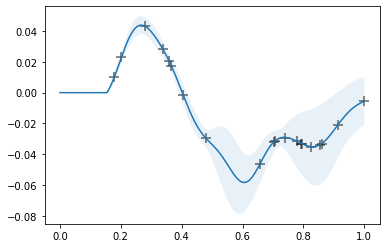

In [280]:
predindenv = AlpEnvelope(fz_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

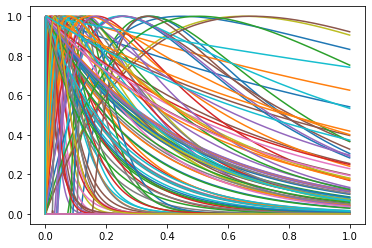

In [281]:
envelopes = AlpEnvelope(ftime, ftrise, ftaudiff, flag).reshape(num_filt, k + 1, 1)
for i in envelopes:
  plt.plot(ftime, i)

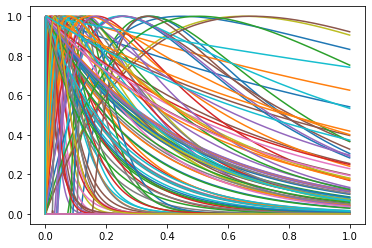

In [282]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

In [283]:
print(np.max(flag))

0.15455549849317518


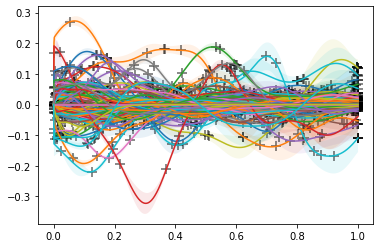

In [284]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vectorf[index], (predindenv * (fcpred @ fv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])
# variance of long-timescale neurons - envelope form, degeneracy

In [285]:
del isigma_ff, iellf, iz_vectorf, iv_vectorf, il_matrixf, itrisef, itaudifff, ilagf, fsigma_ff, fellf, fz_vectorf, fv_vectorf, fl_matrixf, ftrisef, ftaudifff, flagf 

In [286]:
del scisigmaf, sciellf, scitrisef, scitaudifff, scilagf, ikmm, icpred, ikzast, ibzast, ibzastT, ipredenv, ipredenvT, ikastast, scfsigmaf, scfellf, scftrisef, scftaudifff, scflagf, fkmm, fcpred, fkzast, fbzast, fbzastT, fpredenv, fpredenvT, fkastast 

In [61]:
@partial(jit, static_argnums = (1, 2, 3,))
def OUTconvolve(Filters, Num_Filt, K, N, Spike_FFT):
  Pad = jnp.hstack((Filters, jnp.zeros((Num_Filt, N, 1))))
  Pred_fft = jnp.fft.rfft(Pad, axis = -2)
  Pred_sum = jnp.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = jnp.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [288]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, num_filt, k, n, spikefftf[0])
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, num_filt, k, n, spikefftf[0])
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, num_filt, k, n, spikefftf[0])

In [289]:
print(imeanpredict.shape)

(159913, 1)


In [290]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, num_filt, k, n, spikefftf[0])
print(fmeanpredict.shape)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, num_filt, k, n, spikefftf[0])
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, num_filt, k, n, spikefftf[0])

(159913, 1)


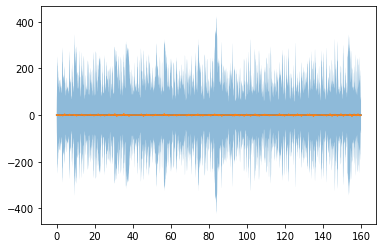

In [291]:
plt.plot(ytime[0], imeanpredict)
plt.plot(ytime[0], yvel[0])
plt.fill_between(ytime[0].flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

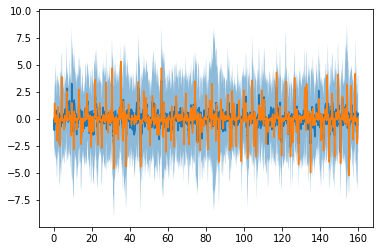

In [292]:
plt.plot(ytime[0], fmeanpredict)
plt.plot(ytime[0], yvel[0])
plt.fill_between(ytime[0].flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

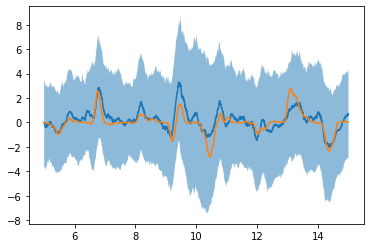

In [293]:
ytesttru = yvel[:, 5000:15000]
ytimetru = ytime[0][5000:15000]
fmeanpredicttru = fmeanpredict[5000:15000]
fmeanpredictns2tru = fmeanpredictns2[5000:15000]
fmeanpredictps2tru = fmeanpredictps2[5000:15000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru[0])
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)
# check adding std, not variance

# X Velocity

In [62]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_mach, batch_size, 1, 1))
iell = 0.002 * jnp.ones ((num_mach, batch_size, 1, 1))
isigma_n = 0.000000005
itrise = np.sqrt(0.05) * jnp.ones((num_mach, batch_size, 1, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_mach, batch_size, 1, 1))

xsigma_f = isigma_f
xell = iell
xsigma_n = isigma_n
xtrise = itrise
xtaudiff = itaudiff
xlag = ilag

# Variational parameters
num_f = 15
num_b = 100
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_mach, batch_size, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_mach, batch_size, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_mach, batch_size, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_mach, batch_size, int((num_ind ** 2 - num_ind) / 2)))
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

xz_fracs = iz_fracs
xv_vector = iv_vector
xl_diag = il_diag
xl_odiag = il_odiag

# Random number generator
iopt_key = np.asarray([random.PRNGKey(i) for i in range(num_mach)]).astype(np.uint32)
itest = vmap(random.split, in_axes=(0, None))(iopt_key, 1 + 4 * num_mach)
iopt_key = np.asarray([itest[i][0] for i in range(num_mach)]).astype(np.uint32)
iopt_subkey = np.asarray([itest[i][1:] for i in range(num_mach)]).astype(np.uint32)

opt_key = iopt_key
opt_subkey = iopt_subkey
print(opt_subkey.shape)

(10, 40, 2)


In [63]:
mad, vad = Init_Adam(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
              il_odiag, itrise, itaudiff, ilag)

In [64]:
step = 0
xelbo_history = np.zeros(20000)

In [65]:
coarse_steps = 1500
mid_steps = 16500
fine_steps = 2000

In [66]:
extra_coarse_steps = 0
extra_mid_steps = 0
extra_fine_steps = 0

In [67]:
xelbo_history = np.hstack((xelbo_history, np.zeros(sum([extra_coarse_steps, extra_mid_steps, extra_fine_steps]))))

In [68]:
step = 0
for i in trange(coarse_steps):  
  xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, st, kt, mad, vad, xvalue = _CUpdate(i, xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, num_f, num_b, num_ind, num_filt, batch_size, k, n, indices, spikefft, xvel, ftime, opt_subkey, opt_key, mad, vad)
  xsigma_n = xsigma_n[0]
  xelbo_history[step] = -xvalue[0]
  step += 1

100%|██████████| 1500/1500 [31:51<00:00,  1.27s/it]


In [69]:
for i in trange(mid_steps):  
  xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, st, kt, mad, vad, xvalue = _MUpdate(i, xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, num_f, num_b, num_ind, num_filt, batch_size, k, n, indices, spikefft, xvel, ftime, opt_subkey, opt_key, mad, vad)
  xsigma_n = xsigma_n[0]
  xelbo_history[step] = -xvalue[0]
  step += 1

 67%|██████▋   | 11057/16500 [3:48:21<1:44:52,  1.16s/it]

In [ ]:
for i in trange(fine_steps):  
  xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, st, kt, mad, vad, xvalue = _FUpdate(i, xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag, num_f, num_b, num_ind, num_filt, batch_size, k, n, indices, spikefft, xvel, ftime, opt_subkey, opt_key, mad, vad)
  xsigma_n = xsigma_n[0]
  xelbo_history[step] = -xvalue[0]
  step += 1

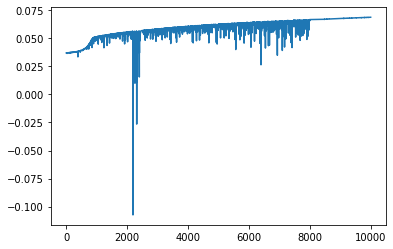

In [ ]:
plt.plot(xelbo_history[10000:])

In [ ]:
print(PNeg(isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag,
                il_odiag, itrise, itaudiff, ilag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, indices, spikefft, yvel, 
                ftime, iopt_subkey))

[2.41050053e+16]


In [ ]:
print(PNeg(xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag,
                xl_odiag, xtrise, xtaudiff, xlag, num_f, num_b,
                num_ind, num_filt, batch_size, k, n, indices, spikefft, xvel, 
                ftime, iopt_subkey))

[-0.06890171]


In [ ]:
xfsigma_f, xfell, xfsigma_n, xfz_fracs, xfv_vector, xfl_diag, xfl_odiag, xftrise, xftaudiff, xflag = xsigma_f, xell, xsigma_n, xz_fracs, xv_vector, xl_diag, xl_odiag, xtrise, xtaudiff, xlag

In [ ]:
xoutdict = {"Parameters": (xfsigma_f, xfell, xfsigma_n, xfz_fracs, xfv_vector, xfl_diag, xfl_odiag, xftrise, xftaudiff, xflag),
          "ELBO History": xelbo_history,
          "Training Sets": trainind,
          "Steps":(coarse_steps, mid_steps, fine_steps, extra_coarse_steps, extra_mid_steps, extra_fine_steps),
          "Initial Parameters": (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag),
          "Training Parameters": (num_f, num_b, num_ind, num_filt),
          "mad": mad,
          "vad": vad,
          "Velocity Trained": "x"}

In [ ]:
with open('./Data/Hyperparameters' + str(n) + '_' + str(attemptno) + 'xvel' + '.pkl', 'wb') as f:
    pickle.dump(xoutdict, f)

In [ ]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
print(il_diag.shape)
print(idz.shape)
il_matrix = PSet(idz, indices, il_odiag)


xflag = xflag ** 2

xfz_vector = (0.5 * np.sin( np.pi * (xfz_fracs - 0.5)) + 0.5) * (ftime[-1] - xflag) + xflag

xfd = PDiag(np.exp(xfl_diag))
xfl_matrix = PSet(xfd, indices, xfl_odiag)
print(xfd.shape)
print(xfl_matrix.shape)

(1, 130, 20)
(1, 130, 20, 20)
(1, 130, 20, 20)
(1, 130, 20, 20)


In [ ]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

xfsigma_ff = xfsigma_f.reshape(num_filt, 1)
xfellf = xfell.reshape(num_filt, 1)
xfz_vectorf = xfz_vector.reshape(num_filt, num_ind, 1)
xfv_vectorf = xfv_vector.reshape(num_filt, num_ind, 1)
xfl_matrixf = xfl_matrix.reshape(num_filt, num_ind, num_ind)
xftrisef = xftrise.reshape(num_filt, 1)
xftaudifff = xftaudiff.reshape(num_filt, 1)
xflagf = xflag.reshape(num_filt, 1)

In [ ]:
print(len(spikefft))

1


In [ ]:
print(len(spikefftf))
print(spikefftf[0].shape)

3
(130, 3001, 1)


In [ ]:
print(xfsigma_ff)

[[0.13233628]
 [0.91606586]
 [0.88582864]
 [0.85399899]
 [0.0404978 ]
 [0.79888756]
 [0.16500194]
 [0.68612809]
 [0.52416362]
 [0.36375886]
 [0.32164703]
 [1.        ]
 [0.41260568]
 [0.69243412]
 [0.87701527]
 [0.42064865]
 [0.70475372]
 [0.92775509]
 [0.86878909]
 [0.55167702]
 [0.39643805]
 [0.64270052]
 [0.17248224]
 [0.80989189]
 [0.42540384]
 [0.48342586]
 [0.03010988]
 [0.42141157]
 [1.08933955]
 [0.27142722]
 [0.46148978]
 [0.160933  ]
 [0.72606042]
 [0.00379267]
 [0.04295259]
 [0.77838129]
 [0.29896026]
 [0.51977749]
 [0.39546161]
 [0.83277933]
 [0.33970277]
 [0.45743335]
 [0.82606332]
 [0.30392474]
 [0.43876927]
 [0.05912326]
 [0.36026243]
 [0.06155584]
 [0.27776191]
 [0.87359707]
 [0.13642627]
 [0.06537213]
 [0.14399784]
 [0.91659353]
 [0.4178902 ]
 [0.34408662]
 [0.21641149]
 [0.40587349]
 [0.0876398 ]
 [0.78188651]
 [0.60769337]
 [0.3997696 ]
 [0.10351805]
 [0.20720796]
 [0.84973137]
 [0.07865999]
 [0.50334615]
 [0.87460699]
 [0.665653  ]
 [1.        ]
 [0.29057857]
 [0.03

In [ ]:
print(xfellf)

[[-0.12144757]
 [-0.05425867]
 [ 0.02906623]
 [ 0.04300499]
 [-0.08153971]
 [ 0.07493278]
 [ 0.06689853]
 [ 0.06915827]
 [-0.07825183]
 [-0.09216132]
 [ 0.09742859]
 [ 0.002     ]
 [-0.10975533]
 [ 0.1184367 ]
 [ 0.06338583]
 [-0.09046741]
 [-0.0605206 ]
 [-0.057866  ]
 [ 0.01742838]
 [ 0.10282713]
 [ 0.07109933]
 [ 0.08646725]
 [-0.11283069]
 [-0.05875586]
 [ 0.10083325]
 [ 0.06781503]
 [ 0.08285981]
 [ 0.11860246]
 [ 0.06825838]
 [-0.1142641 ]
 [-0.07663633]
 [-0.09110869]
 [ 0.07958729]
 [ 0.05161415]
 [-0.11807062]
 [-0.06040693]
 [-0.0894799 ]
 [ 0.07956537]
 [ 0.0789199 ]
 [ 0.05894858]
 [ 0.12457392]
 [-0.09232839]
 [ 0.06348184]
 [-0.11180096]
 [ 0.09258954]
 [-0.10089791]
 [-0.07796478]
 [-0.07508939]
 [ 0.0762152 ]
 [ 0.0704198 ]
 [-0.05785408]
 [-0.11347698]
 [ 0.09010658]
 [-0.0661859 ]
 [ 0.08776158]
 [ 0.10469719]
 [-0.10642259]
 [-0.07369292]
 [-0.06367739]
 [-0.061973  ]
 [ 0.05943547]
 [-0.06013894]
 [ 0.09723419]
 [-0.09870279]
 [ 0.06624884]
 [-0.11357138]
 [ 0.06869

In [ ]:
print(xfsigma_n)

0.010221673368344326


In [ ]:
print(xftrisef)

[[ 1.44475414e-01]
 [-1.92110042e-03]
 [-7.25766236e-03]
 [ 1.25649585e-03]
 [ 1.62976713e-01]
 [ 4.55352049e-03]
 [ 2.68778558e-01]
 [-1.08576633e-03]
 [ 4.85717944e-01]
 [ 1.70384538e-01]
 [ 1.77097306e-01]
 [ 2.23606798e-01]
 [ 1.95407900e-01]
 [ 1.70112183e-01]
 [ 3.52149997e-03]
 [ 7.46010575e-02]
 [-3.74669071e-03]
 [-2.87171906e-03]
 [-3.67693636e-03]
 [ 1.93409366e-01]
 [ 3.45831554e-01]
 [ 2.10159678e-01]
 [ 1.60503623e-01]
 [-1.39479905e-03]
 [ 1.47022656e-01]
 [ 4.21774446e-01]
 [ 1.24347101e-01]
 [ 1.83647932e-01]
 [ 3.69068448e-01]
 [ 1.57092047e-01]
 [ 6.86112052e-02]
 [ 1.40853191e-01]
 [ 2.02188307e-01]
 [ 1.16427593e-01]
 [ 1.57953678e-01]
 [ 4.54680775e-03]
 [ 1.15688957e-01]
 [ 2.49643397e-01]
 [ 2.57114089e-01]
 [ 5.96751254e-04]
 [ 1.43044949e-01]
 [ 2.09546024e-01]
 [ 1.71899714e-03]
 [ 1.37723320e-01]
 [ 2.43027053e-01]
 [ 1.45440965e-01]
 [ 2.42355093e-01]
 [ 1.49422842e-01]
 [ 1.37560519e-01]
 [-1.22390570e-04]
 [ 1.76374174e-01]
 [ 1.53706269e-01]
 [ 1.4865458

In [ ]:
print(xftaudifff)

[[ 2.64439535e-02]
 [ 3.65439688e-04]
 [ 6.06117363e-03]
 [-2.85710817e-03]
 [ 6.14236959e-02]
 [ 2.37325391e-03]
 [ 2.10159092e-01]
 [ 7.57174927e-04]
 [ 3.07109747e-01]
 [ 4.70329161e-02]
 [ 5.67736715e-02]
 [ 1.00000000e-01]
 [ 6.10010124e-02]
 [ 3.24545877e-02]
 [-5.38024719e-04]
 [-1.44804476e-07]
 [-2.11727483e-05]
 [ 1.98291236e-04]
 [-3.95850569e-03]
 [ 9.15524004e-02]
 [ 3.92881928e-01]
 [ 7.75925943e-02]
 [ 6.24261280e-02]
 [ 2.19413392e-04]
 [ 4.98488134e-02]
 [ 1.14012804e-01]
 [-6.48036374e-03]
 [ 1.07275561e-01]
 [ 9.33595464e-02]
 [ 1.82721720e-01]
 [-5.06894137e-03]
 [ 2.77567208e-02]
 [ 8.80829252e-02]
 [ 5.61509158e-02]
 [ 5.07152324e-02]
 [-3.38869773e-05]
 [ 1.64157799e-02]
 [ 4.02089262e-01]
 [ 1.33361569e-01]
 [-2.55846356e-04]
 [ 3.68414215e-02]
 [ 7.27871291e-02]
 [ 7.54602663e-06]
 [ 7.89374249e-02]
 [ 7.23994352e-02]
 [ 4.27197179e-02]
 [ 1.54895513e-01]
 [ 4.92946424e-02]
 [ 3.08341478e-02]
 [ 5.39427304e-04]
 [ 8.63680727e-01]
 [-3.40474601e-02]
 [ 2.5665665

In [ ]:
print(xflagf)

[[2.82098417e-02]
 [4.27556712e-02]
 [1.14328831e-03]
 [8.70594042e-03]
 [6.17332812e-13]
 [3.16986488e-03]
 [3.35765311e-32]
 [2.92445811e-03]
 [1.25495696e-03]
 [2.70988129e-12]
 [1.35907595e-04]
 [1.00000000e-02]
 [2.64350854e-03]
 [1.76398894e-02]
 [1.95345960e-02]
 [9.91137487e-03]
 [4.94803985e-02]
 [4.36798407e-02]
 [2.08528963e-03]
 [3.67179585e-03]
 [1.18357169e-03]
 [1.36411456e-02]
 [1.94263475e-02]
 [3.12470521e-02]
 [4.07389730e-02]
 [3.46377619e-02]
 [4.24673580e-02]
 [9.07637977e-03]
 [6.45471256e-02]
 [3.82131944e-13]
 [5.58666630e-02]
 [3.90396194e-02]
 [1.93201831e-12]
 [5.51234633e-88]
 [2.15566063e-03]
 [5.70805662e-02]
 [5.61293869e-02]
 [6.60162090e-03]
 [4.91971574e-02]
 [2.91735423e-03]
 [4.52561849e-02]
 [3.78480156e-03]
 [3.63058670e-03]
 [3.89413936e-13]
 [2.81880163e-14]
 [7.61889300e-02]
 [8.93554488e-03]
 [6.41514279e-02]
 [4.60335936e-03]
 [1.93208678e-02]
 [3.76583354e-04]
 [3.21232537e-02]
 [1.45678445e-02]
 [3.51481043e-03]
 [5.73683577e-02]
 [3.323233

## Variational Predictions

In [ ]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
del ikmm
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
# ibzast = np.zeros((num_filt, num_ind, k + 1))
# for i in range(num_filt):
#   ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzast = VLS(icpred, ikzast)
del ikzast
del icpred
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)
ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [ ]:
xscfsigmaf = xfsigma_ff[:, None]
xscfellf = xfellf[:, None]
xscftrisef = xftrisef[:, None]
xscftaudifff = xftaudifff[:, None]
xscflagf = xflagf[:, None]

xfkmm = Squared_exp(xfz_vectorf, xfz_vectorf.transpose(0, 2, 1), xscfsigmaf, xscfellf)
xfcpred = np.linalg.cholesky(xfkmm + 1e-6 * np.eye(num_ind))
xfkzast = Squared_exp(xfz_vectorf, fpred_points.T, xscfsigmaf, xscfellf)
xfbzast = np.zeros((num_filt, num_ind, k + 1))
# for i in range(num_filt):
#   xfbzast[i] = sc.linalg.solve_triangular(xfcpred[i], xfkzast[i], lower = True)
xfbzast = VLS(xfcpred, xfkzast)
xfbzastT = xfbzast.transpose(0, 2, 1)
xfpredenv = AlpEnvelope(fpred_points, xscftrisef, xscftaudifff, xscflagf)
xfpredenvT = xfpredenv.transpose(0, 2, 1)
xfmeanpred = xfpredenv * (xfbzastT @ fv_vectorf)

xfkastast = Squared_exp(fpred_points, fpred_points.T, xscfsigmaf, xscfellf)
xfcovpred = xfpredenv * (xfkastast + xfbzastT @ (fl_matrixf @ fl_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ xfbzast) * xfpredenvT

2022-05-22 20:30:09.400682: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 993.81MiB (rounded to 1042081280)requested by op 
2022-05-22 20:30:09.400877: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] **_______________**********************************************************************************x
2022-05-22 20:30:09.400984: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2124] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1042081040 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.94GiB
              constant allocation:         0B
        maybe_live_out allocation:  993.81MiB
     preallocated temp allocation:         0B
                 total allocation:    2.91GiB
              total fragmentation:         0B (0.00%)
Peak buf

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1042081040 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.94GiB
              constant allocation:         0B
        maybe_live_out allocation:  993.81MiB
     preallocated temp allocation:         0B
                 total allocation:    2.91GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 993.81MiB
		Entry Parameter Subshape: f64[130,1001,1001]
		==========================

	Buffer 2:
		Size: 993.81MiB
		Entry Parameter Subshape: f64[130,1001,1001]
		==========================

	Buffer 3:
		Size: 993.81MiB
		Operator: op_name="jit(fn)/jit(main)/add" source_file="/tmp/ipykernel_11098/1518129956.py" source_line=18
		XLA Label: add
		Shape: f64[130,1001,1001]
		==========================





	Buffer 3:
		Size: 993.81MiB
		Operator: op_name="jit(fn)/jit(main)/add" source_file="/tmp/ipykernel_11098/1518129956.py" source_line=18
		XLA Label: add
		Shape: f64[130,1001,1001]




In [ ]:
print(imeanpred.shape)

(130, 1001, 1)


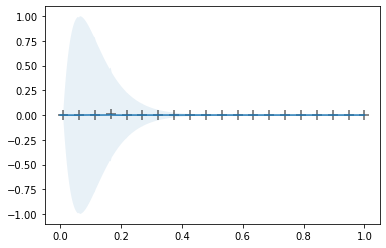

In [ ]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

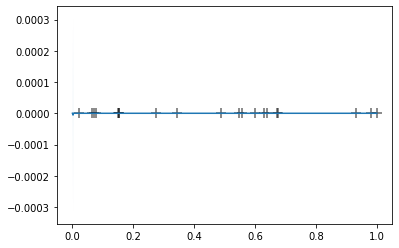

In [ ]:
xpredindenv = AlpEnvelope(xfz_vectorf, xscftrisef, xscftaudifff, xscflagf)

plt.plot(fpred_points, xfmeanpred[index])
xs2 = np.sqrt(np.diag(xfcovpred[index]))
fill = (xfmeanpred[index].flatten() - xs2, xfmeanpred[index].flatten() + xs2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(xfz_vectorf[index], (xpredindenv * (xfcpred @ xfv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

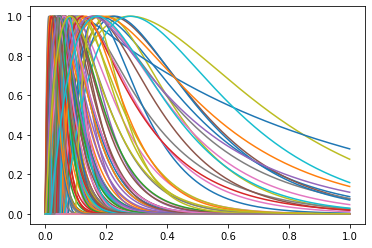

In [ ]:
xenvelopes = AlpEnvelope(ftime, xscftrisef, xscftaudifff, xscflagf)
for i in envelopes:
  plt.plot(ftime, i)

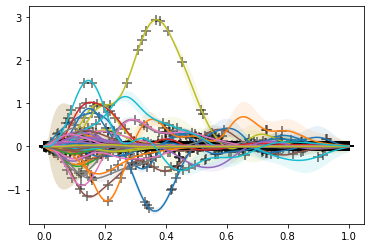

In [ ]:
for index in range(num_filt):
  plt.plot(fpred_points, xfmeanpred[index])
  xs2 = np.sqrt(np.diag(xfcovpred[index]))
  xfill = (xfmeanpred[index].flatten() - xs2, xfmeanpred[index].flatten() + xs2)
  plt.fill_between(fpred_points.flatten(), *xfill, alpha = 0.1)
  plt.scatter(xfz_vectorf[index], (xpredindenv * (xfcpred @ xfv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

In [ ]:
@partial(jit, static_argnums = (1, 2,))
def OUTconvolve(Filters, K, N, Spike_FFT):
  Pad = np.hstack((Filters, np.zeros((num_filt, N, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, k, n, spikefftf[0])
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, k, n, spikefftf[0])
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, k, n, spikefftf[0])

In [ ]:
print(imeanpredict.shape)

(5000, 1)


In [ ]:
xfs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

xfmeanpredict = OUTconvolve(fmeanpred, k, n, spikefftf[2])
print(xfmeanpredict.shape)
xfmeanpredictns2 = OUTconvolve(fmeanpred - 2 * xfs2, k, n, spikefftf[2])
xfmeanpredictps2 = OUTconvolve(fmeanpred + 2 * xfs2, k, n, spikefftf[2])

(5000, 1)


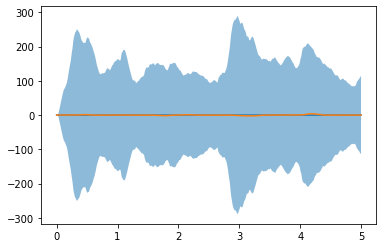

In [ ]:
plt.plot(ytime[0], imeanpredict)
plt.plot(ytime[0], yvel[0])
plt.fill_between(ytime[0].flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

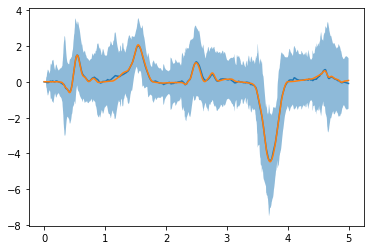

In [ ]:
plt.plot(ytime[2], xfmeanpredict)
plt.plot(ytime[2], xvel[2])
plt.fill_between(ytime[2].flatten(), xfmeanpredictns2.flatten() - 2 * xfsigma_n,  
                  xfmeanpredictps2.flatten() + 2 * xfsigma_n, alpha = 0.5)

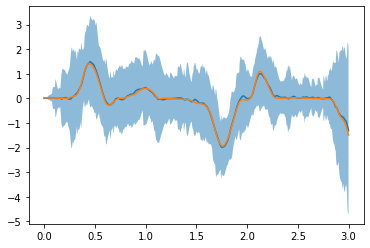

In [ ]:
xytesttru = xvel[:, :3000]
xytimetru = ytime[0][:3000]
xfmeanpredicttru = xfmeanpredict[:3000]
xfmeanpredictns2tru = xfmeanpredictns2[:3000]
xfmeanpredictps2tru = xfmeanpredictps2[:3000]
plt.plot(xytimetru, xfmeanpredicttru)
plt.plot(xytimetru, xytesttru[0])
plt.fill_between(xytimetru.flatten(), xfmeanpredictns2tru.flatten() - 2 * xfsigma_n,  
                  xfmeanpredictps2tru.flatten() + 2 * xfsigma_n, alpha = 0.5)

# On Test Data

In [ ]:
alldata = pd.read_hdf('./Data/Allfinger_veldata.h5') # Import DataFrame

In [ ]:
testind = (3,)

In [ ]:
testdat = [alldata.loc[i] for i in testind]

In [ ]:
testdat[0]

signal_type            finger_vel            spikes                           \
channel                         x          y    201  203  204  301  401  601   
0 days 00:00:00         -1.653753 -14.736100    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  -1.698505 -14.697690    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  -1.742574 -14.657507    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  -1.785958 -14.615533    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  -1.828660 -14.571765    0.0  1.0  0.0  0.0  0.0  0.0   
...                           ...        ...    ...  ...  ...  ...  ...  ...   
0 days 00:02:41.388000  -0.410469   0.023493    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.389000  -0.405038   0.020824    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.390000  -0.399582   0.018134    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.391000  -0.394103   0.015427    0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.392000  -0.388607   0.012704    0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       ...                                          \
channel                 701  802  ... 9001 9103 9201 9203 9301 9403 9501 9502   
0 days 00:00:00         0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.001000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.002000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.003000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:00:00.004000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
0 days 00:02:41.388000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.389000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.390000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.391000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0 days 00:02:41.392000  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

signal_type                       
channel                9601 9602  
0 days 00:00:00         0.0  0.0  
0 days 00:00:00.001000  0.0  0.0  
0 days 00:00:00.002000  0.0  0.0  
0 days 00:00:00.003000  0.0  0.0  
0 days 00:00:00.004000  0.0  0.0  
...                     ...  ...  
0 days 00:02:41.388000  0.0  0.0  
0 days 00:02:41.389000  0.0  0.0  
0 days 00:02:41.390000  0.0  0.0  
0 days 00:02:41.391000  0.0  0.0  
0 days 00:02:41.392000  0.0  0.0  

[161393 rows x 132 columns]

In [ ]:
num_tes = 161393
tes_filt = 130
ntest = num_tes - 1

In [ ]:
testspike = [testdat[i].spikes.to_numpy()[:num_tes, :tes_filt].T[:, :, None] for i in range(len(testind))]

In [ ]:
testpad = [jnp.hstack((i, jnp.zeros((num_filt, k, 1)))) for i in testspike]
print(testpad[0].shape)
testspikefft = jnp.asarray([np.fft.rfft(i, axis = -2) for i in testpad])
print(testspikefft[0].shape)

(130, 162393, 1)
(130, 81197, 1)


In [ ]:
testtime = [(testdat[i].index / np.timedelta64(1, 's')).to_numpy()[:num_tes] for i in range(len(testind))] # Get spikes/output time array

In [ ]:
# Get x and y velocities
yrawtes = [testdat[i].finger_vel.y.to_numpy()[:num_tes].reshape(ntest + 1, 1) for i in range(len(testind))]
xrawtes = [testdat[i].finger_vel.x.to_numpy()[:num_tes].reshape(ntest + 1, 1) for i in range(len(testind))]

## Standardising Data

In [ ]:
# Set variance to 1.0
ytest = np.asarray([yrawtes[i] / np.std(yrawtes[i]) for i in range(len(testind))])

In [ ]:
del testdat # Clear data from memory
del alldata

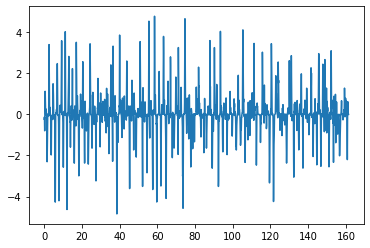

In [ ]:
for i in range(len(testind)):
  plt.plot(testtime[i], ytest[i])

## Plotting vs Test

In [ ]:
tmeanpredict = OUTconvolve(fmeanpred, tes_filt, k, ntest, testspikefft[0])
tmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, tes_filt, k, ntest, testspikefft[0])
tmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, tes_filt, k, ntest, testspikefft[0])

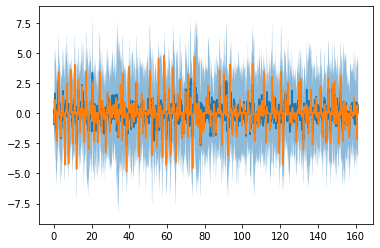

In [ ]:
plt.plot(testtime[0], tmeanpredict)
plt.plot(testtime[0], ytest[0])
plt.fill_between(testtime[0].flatten(), tmeanpredictns2.flatten() - 2 * fsigma_n,  
                  tmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

In [ ]:
plt.plot(testtime[0], tmeanpredict)
plt.plot(testtime[0], xtest[0])
plt.fill_between(testtime[0].flatten(), tmeanpredictns2.flatten() - 2 * xfsigma_n,  
                  tmeanpredictps2.flatten() + 2 * xfsigma_n, alpha = 0.5)

NameError: name 'xtmeanpredict' is not defined

## R^2

## Y Velocity

### Test Data

In [ ]:
alltestpredict = np.asarray([OUTconvolve(fmeanpred, num_filt, k, ntest, i) for i in testspikefft])

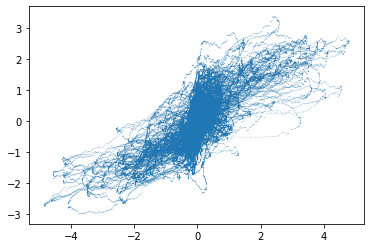

In [ ]:
plt.scatter(ytest.flatten(), alltestpredict.flatten(), s=.005)

In [ ]:
tess = np.sum(np.asarray([np.square(ytest[i] - alltestpredict[i]) for i in range(len(testind))]).flatten())
ttss = np.sum(np.asarray([np.square(ytest[i] - np.mean(ytest[i])) for i in range(len(testind))]).flatten())
tr2 = 1 - tess/ttss
print(tr2)

0.5643075052980642


### Training Data

In [ ]:
allpredict = np.asarray([OUTconvolve(fmeanpred, num_filt, k, n, i) for i in spikefftf])

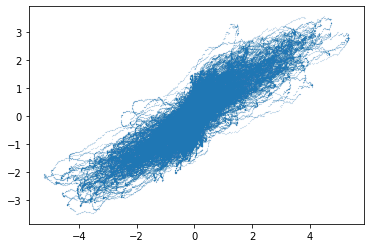

In [ ]:
plt.scatter(yvel.flatten(), allpredict.flatten(), s=.005)

In [ ]:
ess = np.sum(np.asarray([np.square(yvel[i] - allpredict[i]) for i in range(len(trainind))]).flatten())
tss = np.sum(np.asarray([np.square(yvel[i] - np.mean(yvel[i])) for i in range(len(trainind))]).flatten())
r2 = 1 - ess/tss
print(r2)

0.702050652788386


In [ ]:
# sharing envelope over x and y
# angle decoding
# 